In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy.constants import physical_constants
import tinyarray

In [2]:
h_bar = physical_constants['Planck constant over 2 pi'][0]   
m_el = physical_constants['electron mass'][0]         
eV_unit = physical_constants['electron volt'][0]             
el_charge = physical_constants['elementary charge'][0]    
hh = physical_constants['Planck constant'][0]  
mu_B = physical_constants['Bohr magneton'][0]  
mu_B = mu_B/eV_unit
g = -50

In [3]:
m_ef = 0.014* m_el
dx = 4 * 10**(-9) 
alfa = 0.05*10**(-9)
Bh = 0.05
Bext = 0
t_unit_J = h_bar**(2)/(2*m_ef*dx**2) 
t = t_unit_J/eV_unit 
W = 100
L = 800


In [4]:
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])
sigma_law = np.matrix([[1, 0], [0, 2]])

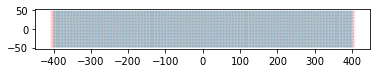

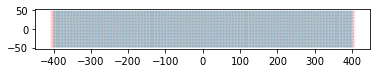

In [5]:
def make_system(alfa = alfa): 
    tso = alfa/(2*dx)
    
    def onsite(site):
        x, y = site.pos
        x = x*dx
        return np.array([[4*t, 0], [0, 4*t]])
    
    def onsite_lead(site):
        x, y = site.pos
        x = x*dx
        return np.array([[4*t, 0], [0, 4*t]])

    def ribbon(pos):
        x, y = pos
        return -L/2 <= x <= L/2 and -W/2 <= y <= W/2

    def shape_lead(pos):
        x,y = pos
        return (-W/2 < y < W/2)

    def hopping_x(site1, site2):
        t_so = 0
        x, y = site1.pos
        if (-0.3*L <= x <= 0.3*L):
            t_so = tso
        return np.array([[-t,0],[0,-t]]) + 1j*t_so*sigma_y
    
    def hopping_y(site1, site2):
        t_so = 0
        x, y = site1.pos
        if (-0.3*L <= x <= 0.3*L):
            t_so = tso
        return np.array([[-t,0],[0,-t]]) + 1j*t_so*sigma_x
    
    def hopping_x_lead(site1, site2):
        t_so = 0
        return np.array([[-t,0],[0,-t]]) + 1j*t_so*sigma_y
    
    def hopping_y_lead(site1, site2):
        t_so = 0
        return np.array([[-t,0],[0,-t]]) + 1j*t_so*sigma_x



    sys = kwant.Builder()  
    lat = kwant.lattice.square(dx*10**9, norbs=2)
    sys[lat.shape(ribbon,(0,0))] = onsite
    sys[(kwant.builder.HoppingKind((-1,0), lat, lat))] = hopping_x
    sys[(kwant.builder.HoppingKind((0,-1), lat, lat))] = hopping_y
    

    leadl = kwant.Builder(kwant.TranslationalSymmetry((-dx*10**9,0)),conservation_law=sigma_law)
    leadl[lat.shape(shape_lead, (0,0))] = onsite_lead
    leadl[(kwant.builder.HoppingKind((-1,0), lat, lat))] = hopping_x_lead
    leadl[(kwant.builder.HoppingKind((0,-1), lat, lat))] = hopping_y_lead

    leadr = kwant.Builder(kwant.TranslationalSymmetry((dx*10**9,0)),conservation_law=sigma_law)
    leadr[lat.shape(shape_lead, (0,0))] = onsite_lead
    leadr[(kwant.builder.HoppingKind((-1,0), lat, lat))] = hopping_x_lead
    leadr[(kwant.builder.HoppingKind((0,-1), lat, lat))] = hopping_y_lead


    sys.attach_lead(leadl)
    sys.attach_lead(leadr)

    sysf = sys.finalized()

    return sysf
sysf = make_system()
kwant.plot(sysf)

In [6]:
def disperssion(nr_lead, k_max, nk):
    momenta = np.linspace(-k_max,k_max,nk)
    bands=kwant.physics.Bands(sysf.leads[nr_lead])
    energies=[bands(k) for k in momenta]
    return (momenta/4), energies

def conductance(Emax, ne):
    energies=np.linspace(0,Emax,ne)
    cond=[transmission(E) for E in energies]
    return energies, cond

def transmission(E):
    smatrix=kwant.smatrix(sysf,E)
    t=smatrix.transmission(1,0) 
    return t

def transmission_up_down(E):
    smatrix=kwant.smatrix(sysf,E)
    t=smatrix.transmission((1,1), (0,0)) 
    return t

def transmission_down_down(E):
    smatrix=kwant.smatrix(sysf,E)
    t=smatrix.transmission((1,1), (0,1)) 
    return t

def transmission_down_up(E):
    smatrix=kwant.smatrix(sysf,E)
    t=smatrix.transmission((1,0), (0,1)) 
    return t

def transmission_up_up(E):
    smatrix=kwant.smatrix(sysf,E)
    t=smatrix.transmission((1,1), (0,1)) 
    return t

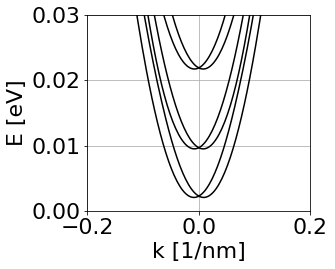

In [8]:
# momenta, energies = disperssion(0, 1, 200)
# plt.figure(figsize=(4,4))
# plt.plot(momenta, np.asarray(energies),'k-')
# plt.tick_params(axis='both', which='major', labelsize=22)
# plt.ylim((0,0.03))  
# plt.xlim((-0.2,0.2))  
# plt.xlabel("k [1/nm]",fontsize=22)
# plt.ylabel("E [eV]",fontsize=22)
# plt.subplots_adjust(bottom=0.2) 
# plt.grid()
# plt.savefig("dyspersja_7jpg.png")
# plt.show()

/root/miniconda3/envs/pykwant2021/lib/python3.8/site-packages/kwant/system.py:316: UserWarning: Hamiltonian breaks Conservation law, ignoring the symmetry in the computation.
  warnings.warn('Hamiltonian breaks ' + name +


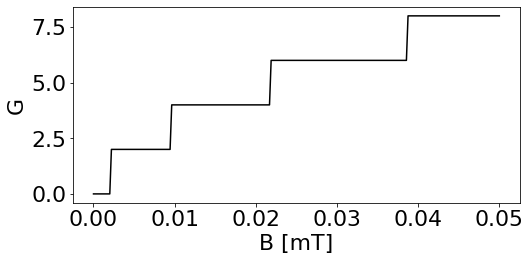

In [11]:
# energies, cond=conductance(0.05,250)
# plt.figure(figsize=(8,4))
# plt.plot(energies, cond,'k-')
# plt.tick_params(axis='both', which='major', labelsize=22)
# plt.xlabel("B [mT]",fontsize=22)
# plt.ylabel("G",fontsize=22)
# plt.subplots_adjust(bottom=0.2) 
# plt.savefig("konduktancja_4.png")
# plt.show()

In [9]:
alfamax = 0.05*10**(-9)
ne = 100
E = 0.005
alfa_table=np.linspace(0,alfamax,ne)
t_down_down = []
t_down_up = []
t_up_down = []
t_up_up = []
for al in alfa_table:
    sysf = make_system(al)
    t_down_down.append(transmission_down_down(E))
    t_up_down.append(transmission_up_down(E))
    t_down_up.append(transmission_down_up(E))
    t_up_up.append(transmission_up_up(E))
    print(al)


0.0
5.050505050505052e-13
1.0101010101010103e-12
1.5151515151515155e-12
2.0202020202020206e-12
2.5252525252525258e-12
3.030303030303031e-12
3.535353535353536e-12
4.040404040404041e-12
4.545454545454547e-12
5.0505050505050515e-12
5.555555555555556e-12
6.060606060606062e-12
6.5656565656565674e-12
7.070707070707072e-12
7.575757575757577e-12
8.080808080808082e-12
8.585858585858588e-12
9.090909090909094e-12
9.595959595959598e-12
1.0101010101010103e-11
1.0606060606060609e-11
1.1111111111111113e-11
1.1616161616161618e-11
1.2121212121212124e-11
1.262626262626263e-11
1.3131313131313135e-11
1.3636363636363639e-11
1.4141414141414144e-11
1.4646464646464648e-11
1.5151515151515154e-11
1.565656565656566e-11
1.6161616161616165e-11
1.666666666666667e-11
1.7171717171717176e-11
1.7676767676767682e-11
1.8181818181818187e-11
1.868686868686869e-11
1.9191919191919195e-11
1.96969696969697e-11
2.0202020202020206e-11
2.0707070707070712e-11
2.1212121212121217e-11
2.1717171717171723e-11
2.2222222222222225e-11
2.2

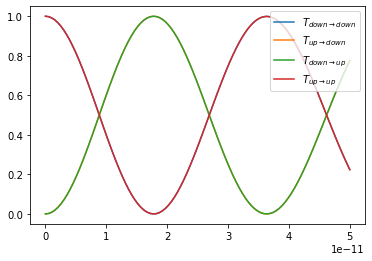

In [10]:
plt.plot(alfa_table, t_down_down, label = r"$T_{down \rightarrow down}$")
plt.plot(alfa_table, t_up_down, label = r"$T_{up \rightarrow down}$")
plt.plot(alfa_table, t_down_up, label = r"$T_{down \rightarrow up}$")
plt.plot(alfa_table, t_up_up, label = r"$T_{up \rightarrow up}$")
plt.legend()
plt.savefig("transmisja_2.png")
plt.show()

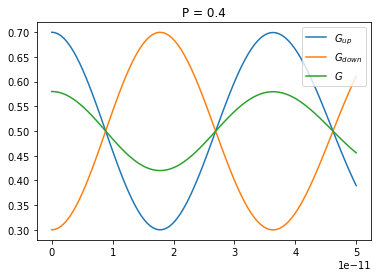

In [73]:
P = 0.4
t_up_up = np.array(t_up_up)
t_down_up = np.array(t_down_up)
t_down_down = np.array(t_down_down)
t_up_down = np.array(t_up_down)
G_up_table = ((1+P)/2 * t_up_up + (1-P)/2 * t_down_up)
G_down_table = ((1+P)/2 * t_up_down + (1-P)/2 * t_down_down)
G_table = (1+P)/2 * G_up_table + (1-P)/2 * G_down_table
plt.plot(alfa_table, G_up_table, label = r"$G_{up}$")
plt.plot(alfa_table, G_down_table, label = r"$G_{down}$")
plt.plot(alfa_table, G_table, label = r"$G$")
plt.title("P = 0.4")
plt.legend()
plt.savefig("P_04.jpg")
plt.show()

In [72]:
sysf = make_system(0.057*10**(-9))
wave_f=kwant.wave_function(sysf,energy = 0.005)(0)
density_up=tinyarray.array([[1,0],\
[0,0]])
density_down=tinyarray.array([[0,0],\
[0,1]])
density_both=tinyarray.array([[1,0],\
[0,1]])

density_up_op=kwant.operator.Density(sysf,density_up)
density_down_op=kwant.operator.Density(sysf,density_down)
density_both_op=kwant.operator.Density(sysf,density_both)
density_up_map=density_up_op(wave_f[0])
kwant.plotter.map(sysf,density_up_map, file = "spin_up_2.png")
density_down_map=density_down_op(wave_f[0])
kwant.plotter.map(sysf,density_down_map, file = "spin_down_2.png")
density_both_map=density_both_op(wave_f[0])

/tmp/ipykernel_21067/2687353478.py:14: RuntimeWarning: The plotted data contains 0.30% of values overflowing upper limit 1.98433 
  kwant.plotter.map(sysf,density_up_map, file = "spin_up_2.png")


/tmp/ipykernel_21067/2519696473.py:12: RuntimeWarning: The plotted data contains 0.04% of values underflowing lower limit -1.82576 
  kwant.plotter.map(sysf, spin_x_map, file="spin_x_density_2.png", cmap="RdBu_r")
/tmp/ipykernel_21067/2519696473.py:13: RuntimeWarning: The plotted data contains 0.18% of values overflowing upper limit 0.586344 
  kwant.plotter.map(sysf, spin_y_map, file="spin_y_density_2.png", cmap="RdBu_r")


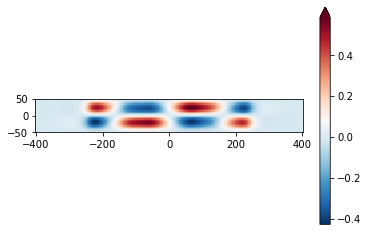

In [71]:
spin_z_op = kwant.operator.Density(sysf, sigma_z)
spin_x_op = kwant.operator.Density(sysf, sigma_x)
spin_y_op = kwant.operator.Density(sysf, sigma_y)

# Obliczamy lokalną gęstość spinu z funkcji falowej (np. kanał 0)
spin_z_map = spin_z_op(wave_f[0])
spin_x_map = spin_x_op(wave_f[0])
spin_y_map = spin_y_op(wave_f[0])

# Rysujemy gęstość spinu
kwant.plotter.map(sysf, spin_z_map, file="spin_z_density_2.png", cmap="RdBu_r")
kwant.plotter.map(sysf, spin_x_map, file="spin_x_density_2.png", cmap="RdBu_r")
kwant.plotter.map(sysf, spin_y_map, file="spin_y_density_2.png", cmap="RdBu_r")